In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
'''
https://github.com/sujiongming/UCF-101_video_classification
'''



# utility
import os
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

##Train Data <br>
* 이미지 데이터 전처리 : Data Augmentation
* Generator 생성
* Model 생성 : Inception V3
* Model 학습 및 저장

In [ ]:
train_dir = '/content/gdrive/MyDrive/dataa/train'
validation_dir = '/content/gdrive/MyDrive/dataa/validation'
test_dir = '/content/gdrive/MyDrive/dataa/test'


# Helper: Save the min val_loss model in each epoch.
checkpointer = ModelCheckpoint(
    filepath='/content/gdrive/MyDrive/dataa/.{epoch:03d}-{val_loss:.2f}.hdf5',
    verbose=1,
    save_best_only=True)

# Helper: Stop when we stop learning.
# patience: number of epochs with no improvement after which training will be stopped.
early_stopper = EarlyStopping(patience=10)

# Helper: TensorBoard
tensorboard = TensorBoard(log_dir='/data/logs/')



def get_generators():
  
    '''train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2)'''

    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

    return train_generator, validation_generator

def get_model(weights='imagenet'):
    # create the base pre-trained model
    base_model = InceptionV3(weights=weights, include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 5 classes
    for _, dirs, _ in os.walk(train_dir):
      break
    predictions = Dense(len(dirs), activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def fine_tune_inception_layer(model):
    """After we fine-tune the dense layers, train deeper."""
    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 172 layers and unfreeze the rest:
    for layer in model.layers[:172]:
        layer.trainable = False
    for layer in model.layers[172:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    model.compile(
        optimizer=SGD(lr=0.001, momentum=0.9),                                      # 변경 lr 0.0001 -> 0.001
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy'])

    return model

def train_model(model, nb_epoch, generators, callbacks=[]):
    train_generator, validation_generator = generators
    model.fit(
        train_generator,
        steps_per_epoch=100,
        validation_data=validation_generator,
        validation_steps=10,
        epochs=nb_epoch,
        callbacks=callbacks)
    return model

def main(weights_file):

    model = get_model()
    generators = get_generators()

    if weights_file is None:
        print("Training Top layers.")
        model = train_model(model, 10, generators)
    else:
        print("Loading saved model: %s." % weights_file)
        model.load_weights(weights_file)

    # Get and train the mid layers.
    model = fine_tune_inception_layer(model)
    model = train_model(model, 20, generators,
                        [checkpointer, early_stopper, tensorboard])

if __name__ == '__main__':
    weights_file = None
    main(weights_file)

87924736/87910968 [==============================] - 1s 0us/step
Found 27778 images belonging to 30 classes.
Found 598 images belonging to 30 classes.
Training Top layers.
Epoch 1/10
100/100 [==============================] - 862s 8s/step - loss: 3.0128 - accuracy: 0.4282 - val_loss: 0.8241 - val_accuracy: 0.7750
Epoch 2/10
100/100 [==============================] - 770s 8s/step - loss: 0.6425 - accuracy: 0.8237 - val_loss: 0.5276 - val_accuracy: 0.8531
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8743

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


100/100 [==============================] - 756s 8s/step - loss: 0.3938 - accuracy: 0.8743 - val_loss: 0.6545 - val_accuracy: 0.8250
Epoch 4/10
100/100 [==============================] - 770s 8s/step - loss: 0.3192 - accuracy: 0.9028 - val_loss: 0.5201 - val_accuracy: 0.8531
Epoch 5/10
100/100 [==============================] - 762s 8s/step - loss: 0.2643 - accuracy: 0.9128 - val_loss: 0.7565 - val_accuracy: 0.8594
Epoch 6/10
100/100 [==============================] - 755s 8s/step - loss: 0.2142 - accuracy: 0.9328 - val_loss: 0.5612 - val_accuracy: 0.8469
Epoch 7/10
100/100 [==============================] - 761s 8s/step - loss: 0.1963 - accuracy: 0.9428 - val_loss: 0.6487 - val_accuracy: 0.8375
Epoch 8/10
100/100 [==============================] - 753s 8s/step - loss: 0.2039 - accuracy: 0.9394 - val_loss: 0.4470 - val_accuracy: 0.9031
Epoch 9/10
100/100 [==============================] - 754s 8s/step - loss: 0.1757 - accuracy: 0.9470 - val_loss: 0.5420 - val_accuracy: 0.8656
Epoch 10/1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
100/100 [==============================] - 1427s 14s/step - loss: 0.3487 - accuracy: 0.9126 - top_k_categorical_accuracy: 0.9877 - val_loss: 0.6921 - val_accuracy: 0.8656 - val_top_k_categorical_accuracy: 0.9937

Epoch 00001: val_loss improved from inf to 0.69206, saving model to /content/gdrive/MyDrive/dataa/.001-0.69.hdf5
Epoch 2/20
100/100 [==============================] - 1385s 14s/step - loss: 0.0904 - accuracy: 0.9748 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5096 - val_accuracy: 0.8969 - val_top_k_categorical_accuracy: 0.9875

Epoch 00002: val_loss improved from 0.69206 to 0.50958, saving model to /content/gdrive/MyDrive/dataa/.002-0.51.hdf5
Epoch 3/20
100/100 [==============================] - 1398s 14s/step - loss: 0.0706 - accuracy: 0.9781 - top_k_categorical_accuracy: 0.9997 - val_loss: 0.6550 - val_accuracy: 0.8813 - val_top_k_categorical_accuracy: 0.9875

Epoch 00003: val_loss did not improve from 0.50958
Epoch 4/20
100/100 [===========================

##Test Data


In [ ]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

model = load_model('/content/gdrive/MyDrive/dataa/.008-0.44.hdf5')

scores = model.evaluate(test_generator)
print("\n최종 %s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

Found 600 images belonging to 30 classes.
19/19 [==============================] - 184s 9s/step - loss: 0.3764 - accuracy: 0.9150 - top_k_categorical_accuracy: 0.9800

최종 accuracy: 91.50%


In [ ]:
# test 데이터 전체 예측
from PIL import Image
import matplotlib.pyplot as plt

folders = os.listdir(test_dir) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음

for i in range(len(folders)):
  path = test_dir + "/" + folders[i] 
  os.chdir(path) # 해당 폴더로 이동
  files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
  for j in range(2):
    test_image = path + '/' + files[j]
    img = Image.open(test_image)
    img = img.convert("RGB")
    img = img.resize((150,150))
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, 150, 150,3)

    # 예측
    model = load_model('/content/gdrive/MyDrive/dataa/.002-0.37.hdf5')
    pred = model.predict(X)  
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    categories = ["bag", "battery", "bed", "blanket", "brush", "computer", "cosmetic", " dish", "doll", "dryer", "flower_pot", "frame", "icepack", "latex", "mask", "mat", "mattress", "monitor", "pan", "pillow", "pot", "puzzle", "sand", "shoes", "stroller", "table", "toy", "umbrella", "vacuum", "wood"]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(label=folders[i]+'->'+categories[result[0]], loc='center')
    plt.show()

### 분리배출 솔루션

In [ ]:
import pandas as pd

df = pd.read_csv("/content/gdrive/MyDrive/분리배출방법.csv")
df

,제품영문,제품한글,배출방법
0,bag,가방,일반 쓰레기
1,battery,건전지,아파트 또는 주민센터 폐건전지 수거함에 버리기
2,bed,침대 틀,일반 쓰레기
3,blanket,담요,일반 쓰레기
4,brush,칫솔,일반 쓰레기
5,computer,컴퓨터,"하드디스크 분리, 폐기, 포맷 후 고물상에 처분 / 중고거래 / 폐기물 스티커 부착..."
6,cosmetic,화장품,"내용물은 휴지, 신문지, 두꺼운 종이 같은데 싸거나 흡수시켜서 일반쓰레기로 배출하기..."
7,dish,접시,일반 쓰레기
8,doll,인형,일반 쓰레기
9,dryer,건조대,폐기물 스티커 부착해서 버리기


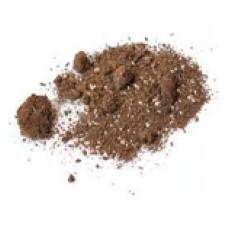

모래 을(를) 버리시는군요!
배출방법은 비닐봉투에 밀봉 후 특수규격 봉투(종량제 마대)에 배출하기


In [ ]:
def test(test_image):   
    img = Image.open(test_image)
    img = img.convert("RGB")
    img = img.resize((150,150))
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, 150, 150,3)

    # 예측
    model = load_model('/content/gdrive/MyDrive/dataa/.002-0.37.hdf5')
    pred = model.predict(X)  
    result = [np.argmax(value) for value in pred]
    category = df['제품한글'][result[0]]
    solution = df['배출방법'][result[0]]

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print( category + " 을(를) 버리시는군요!\n" + "배출방법은 " + solution) 


test("/content/gdrive/MyDrive/dataa/test/sand/images (12).jpeg")    